<H1>Classification Models for Stock Price Movement Based on Sentiment Analysis of News, Price Movement Indicators, and Index Data</H1>

<p>In this notebook, I will use various classification models to explore which technique works best for predicting stock price movement. For a full description of the data, please the accompanying report to this notebook but in short, news stories for most stocks were gathered using the EOD API with accompanying sentiment analysis scores of "polarity", "Neutral", "Negative", and "Positive". A weak correlation was noticed between highly positive sentiment analysis of a news story about a specific stock and a price increase of that stock the following day. </p>
<p>The hypthosis behing this notebook is that including stock indicators such as exponential moving averages, relative strength index, moving average convergence/divergence, etc. as well as index data to reflect the conditions of the overall market will do a better job at predicting whether the price of a stock will go up, stay relativily stable, or go down.

<H2>Loading packages and data</H2>

In [30]:
import pandas as pd, numpy as np, os, pickle as pkl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
os.chdir(r'G:\My Drive\Personal Stuff\Coursera Coursework\Mach learning\Course3')
data = pd.read_pickle('Course3_Final_Project_DataToUseB_BetterBins_241124.pkl')

<H2>Preparing the data for modeling</H2>
<p>Let's look at the balance of classes and distributions and then scale the data using StandardScalar</p>

In [4]:
data.head()

,polarity,neg,neu,pos,y_gains_losses_perc,y_open_close_diff,y_high_low_diff,dist_to_ema9,dist_to_ema20,dist_to_ema200,...,dji_dist_to_ema20,dji_dist_to_ema200,dji_dist_to_sma20,dji_dist_to_sma50,dji_dist_to_sma200,dji_dist_to_vwap9,dji_dist_to_vwap20,dji_dist_to_vwap200,dji_MACD_signal_m_line,Bin
0,0.995,0.003,0.896,0.101,-0.050265,-0.007874,0.028871,-0.011024,0.293348,0.296296,...,-0.67925,-0.686077,0.021018,0.013763,-0.00039,0.016546,0.021223,-0.002744,-1.6559,2
1,0.993,0.016,0.860,0.124,-0.017878,-0.012941,0.020000,0.018207,0.682060,0.688915,...,-0.67925,-0.686077,0.021018,0.013763,-0.00039,0.016546,0.021223,-0.002744,-1.6559,1
2,0.992,0.012,0.866,0.123,0.001332,-0.000858,0.010300,0.000923,0.189674,0.191581,...,-0.67925,-0.686077,0.021018,0.013763,-0.00039,0.016546,0.021223,-0.002744,-1.6559,1
3,0.992,0.012,0.866,0.123,0.001332,-0.000858,0.010300,0.000923,0.189674,0.191581,...,-0.67925,-0.686077,0.021018,0.013763,-0.00039,0.016546,0.021223,-0.002744,-1.6559,1
4,0.994,0.066,0.825,0.110,0.039216,0.030303,0.131313,-0.088230,0.185489,0.187353,...,-0.67925,-0.686077,0.021018,0.013763,-0.00039,0.016546,0.021223,-0.002744,-1.6559,0


In [5]:
data.shape

(108534, 44)

For a full description of the data refer to the pdf report included alongside this notebook but briefly I will describe the main variables here.<br> 
The first four variables in the data are from the sentiment analysis of a news item about that stock - including a measure of polarity, positive, negative, and neutral.<br>
We also have many variables related to the stocks recent movements such as yesterday's gains or losses, the difference between the high and low yesterday, and the distance (as a percentage of the price) to indicators such as exponential moving averages. These same metrics are calculated for indices to reflect the overall stock market where SPY represents the S&P 500 and DJI represents the Dow Jones Industrial Index. <br>
Finally, the outcome variable is "Bin" where price movement of the stock (difference between the close and open the day after news was released) is categorized into three bins:<br>
Bin 0 = the price of the stock dropped by >1.5%<br>
Bin 1 = the price of the stock stayed within 1.5% of its price before the news<br>
Bin 2 = the price of the stock went up by >1.5%<br>

In [6]:
value_counts = data['Bin'].value_counts().reset_index() 
value_counts.columns = ['Bin', 'Count'] # Output the table print
value_counts = value_counts.sort_values(by='Bin')
print(value_counts)

   Bin  Count
1    0  24985
0    1  60012
2    2  23537


<p>We see that Bin 1 is over-represented by a factor of 2-3 compared to the other bins. We can consider balancing the classes using oversampling, undersampling, or a resampling technique but I like the balancing as it is. My reasoning is that we do want to be conservative with our predictions of movement as those are the stocks we will be taking risks on. We are more concerned with making false positive predictions that would lead to us losing as we are with missing a an opportunity to buy a stock (a false negative) because there are many stocks that make these kinds of price movements based on news every day.</p>
<p>In short, I have decided not to do any rebalancing of classes</p>
<p>I will, however, scale the data</p>

In [7]:
X_raw = data.iloc[:, :-1]
y_raw = data.iloc[:, -1:]

We must split the data into training and test sets before scaling. We will fit the scalar on the training set and use that to fit the test set so the models learn to generalize from the training set to new data rather than specific statistic of new data. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42)

In [9]:
value_counts = y_train.value_counts().reset_index() 
value_counts.columns = ['Bin', 'Count'] # Output the table print
value_counts = value_counts.sort_values(by='Bin')
print(value_counts)

   Bin  Count
1    0  19988
0    1  48009
2    2  18830


In [10]:
value_counts = y_test.value_counts().reset_index() 
value_counts.columns = ['Bin', 'Count'] # Output the table print
value_counts = value_counts.sort_values(by='Bin')
print(value_counts)

   Bin  Count
1    0   4997
0    1  12003
2    2   4707


By checking the value counts of y_train and y_test, we are ensuring that the balance (or imbalance in this case) of the original data is preserved. We can see that the ratios of each class is approximately preserved.

In [11]:
SS = StandardScaler()
X_train_scaled = SS.fit_transform(X_train)
X_test_scaled = SS.transform(X_test)

In [14]:
y_train.shape

(86827, 1)

In [16]:
# We need to transform our Y input to a 1d array for propel model input
y_train_ravel = y_train.values.ravel()

Now we have our scaled training and test sets, we are ready to train some models.

<H2>Models</H2>
<p>In this section, we will build several classification models and consider various metrics for assessing their performance</p>

<H4>Logistic Regression with elasticnet</H4>

In [20]:
penalty= 'elasticnet'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use saga for L1 penalty and multinomial classes
solver = 'saga'
# Max iteration = 1000
max_iter = 1000
l1_ratio = 0.1
rs = 42
EN_model = LogisticRegression(random_state=rs, penalty=penalty, multi_class=multi_class, solver=solver, max_iter = 10000, l1_ratio=l1_ratio)
# Note - I trained this model once with 1000 iteration but it warned the coefficients may not have converged so I changed to 10000 iterations.

In [21]:
EN_model.fit(X_train_scaled, y_train_ravel)

LogisticRegression(l1_ratio=0.1, max_iter=10000, multi_class='multinomial',
                   penalty='elasticnet', random_state=42, solver='saga')

In [ ]:
# This function returns performance metrics in a nice dictionary
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [25]:
EN_preds = EN_model.predict(X_test_scaled)
evaluate_metrics(y_test, EN_preds)

{'accuracy': 0.5745612014557516,
 'recall': array([0.1574945 , 0.94609681, 0.0698959 ]),
 'precision': array([0.43528761, 0.59693019, 0.376     ]),
 'f1score': array([0.23130051, 0.73200761, 0.1178789 ])}

The metrics don't look all that great but lets have a look at the 3x3 confusion matrix

In [27]:
cf = confusion_matrix(y_test, EN_preds)

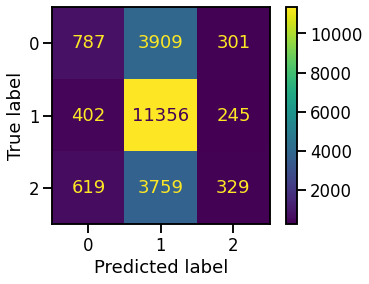

In [ ]:
cf = confusion_matrix(y_test, EN_preds)
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=EN_model.classes_)
disp.plot()
plt.show()

<p>A metric that I'd like to consider are the values that the model got very wrong - when it predicts 2 classes different from the true value. So I will consider the ratio of correctly predicted "2" class to predicted "2"s that were really 0s. This is important because predicted 2s are ones that you're likely to buy. If you buy a stock and it doesn't really change price, that's not a big deal. But what we really want to avoid is buying a stock and having it go down. If we were interesting in shorting stocks, we could also look at predicted 0s that were really 2s.</p>
<p>Here we see that the if the model tells us to buy a stock (class 2), it is almost as likely to go down (class 0) as it is to go up (329 correctly predicted 2s vs 301 predicted 2s really being 0s). This is seemingly very bad, however, it's possible that if you can recognize that a stock is starting to go down and sell it before you lose the full amount, you can build a winning strategy off of this. If you make 1.5% on all your winners but only lose 0.5% on your losers, you only have to be right about your winners 1/3 of the time.</p>
<p>If you're interested in shorting stocks (short stocks is essentially betting that they'll go down), this model performs slightly better (787 correctly predicted 0s vs 619 predicted 0s really being 2s). </p>
<p>Nevertheless, we should try some other model types and see if they do better.</p>

<H3>Support Vector Machines (SVM)</H3>

Let's first try a default SVM and then we'll use grid search to see if we can get better results by tuning two hyperparameters: the kernal type and the regularization parameter c. 

In [41]:
##Default SVM
SVMmodel = SVC()
SVMmodel.fit(X_train_scaled, y_train_ravel)

SVC()

In [42]:
SVM1_preds = SVMmodel.predict(X_test_scaled)
evaluate_metrics(y_test, SVM1_preds)

{'accuracy': 0.5876445386280923,
 'recall': array([0.17430458, 0.95217862, 0.09687699]),
 'precision': array([0.51507983, 0.59513643, 0.56157635]),
 'f1score': array([0.26046651, 0.73246387, 0.16524733])}

In [ ]:
params_grid = {
    'C': [1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
model = SVC()

In [ ]:
# Define a GridSearchCV to search the best parameters
grid_search = GridSearchCV(estimator = model, 
                           param_grid = params_grid, 
                           scoring='accuracy',
                           cv = 5, verbose = 1)
# Search the best parameters with training data
grid_search.fit(X_train_scaled, y_train_ravel)
best_params = grid_search.best_params_
best_params

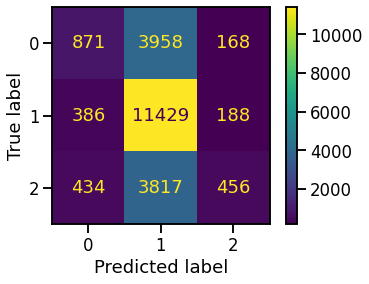

In [43]:
cf = confusion_matrix(y_test, SVM1_preds)
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=EN_model.classes_)
disp.plot()
plt.show()

<H3>Random Forest Model</H3>

In [33]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

In [34]:
model = RandomForestClassifier()
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
search.fit(X_train_scaled, y_train_ravel)
search.best_score_

c:\Users\sethr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1000 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sethr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sethr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\sethr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\b

0.6768171192396195

In [35]:
search.best_params_

{'max_depth': 19, 'max_features': 'log2', 'n_estimators': 39}

In [38]:
##Let's go ahead and make our model using the best parameters so we can look at other metrics and the confusion matrix
Best_RF_model = RandomForestClassifier(n_estimators= 39, max_depth= 19, max_features='log2')
Best_RF_model.fit(X_train_scaled, y_train_ravel)
Best_RF_preds = Best_RF_model.predict(X_test_scaled)
evaluate_metrics(y_test, Best_RF_preds)

{'accuracy': 0.6836504353434376,
 'recall': array([0.43946368, 0.90818962, 0.37029955]),
 'precision': array([0.66545455, 0.68767348, 0.68219178]),
 'f1score': array([0.52934796, 0.7826961 , 0.48003305])}

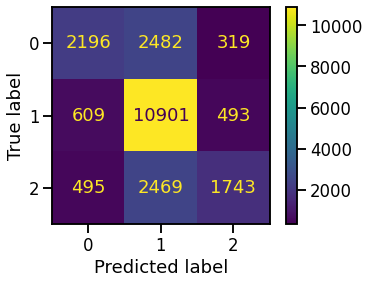

In [39]:

cf = confusion_matrix(y_test, Best_RF_preds)
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=EN_model.classes_)
disp.plot()
plt.show()